# Data Exploration

In [3]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("C:/Users/aceme/OneDrive/Documents/SIAM Simons Summer Opportunity/Datasets/WVS_Cross-National_Wave_7_csv_v6_0.csv")

In [4]:
df.head()

,version,doi,A_WAVE,A_YEAR,A_STUDY,B_COUNTRY,B_COUNTRY_ALPHA,C_COW_NUM,C_COW_ALPHA,D_INTERVIEW,...,WVS_Polmistrust_PartyVoter,WVS_LR_MedianVoter,WVS_LibCon_MedianVoter,v2psbars,v2psorgs,v2psprbrch,v2psprlnks,v2psplats,v2xnp_client,v2xps_party
0,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,20070001,...,62.434211,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,20070002,...,62.434211,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,20070003,...,62.434211,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,20070004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,20070005,...,66.964286,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [21]:
# Column names
print(df.columns.values)

['version' 'doi' 'A_WAVE' 'A_YEAR' 'A_STUDY' 'B_COUNTRY' 'B_COUNTRY_ALPHA'
 'C_COW_NUM' 'C_COW_ALPHA' 'D_INTERVIEW' 'S007' 'J_INTDATE' 'FW_START'
 'FW_END' 'K_TIME_START' 'K_TIME_END' 'K_DURATION' 'Q_MODE' 'N_REGION_ISO'
 'N_REGION_WVS' 'N_REGION_NUTS2' 'N_REG_NUTS1' 'N_TOWN' 'G_TOWNSIZE'
 'G_TOWNSIZE2' 'H_SETTLEMENT' 'H_URBRURAL' 'I_PSU' 'O1_LONGITUDE'
 'O2_LATITUDE' 'L_INTERVIEWER_NUMBER' 'S_INTLANGUAGE' 'LNGE_ISO'
 'E_RESPINT' 'F_INTPRIVACY' 'E1_LITERACY' 'W_WEIGHT' 'S018' 'PWGHT' 'S025'
 'Q1' 'Q2' 'Q3' 'Q4' 'Q5' 'Q6' 'Q7' 'Q8' 'Q9' 'Q10' 'Q11' 'Q12' 'Q13'
 'Q14' 'Q15' 'Q16' 'Q17' 'Q18' 'Q19' 'Q20' 'Q21' 'Q22' 'Q23' 'Q24' 'Q25'
 'Q26' 'Q27' 'Q28' 'Q29' 'Q30' 'Q31' 'Q32' 'Q33' 'Q33_3' 'Q34' 'Q34_3'
 'Q35' 'Q35_3' 'Q36' 'Q37' 'Q38' 'Q39' 'Q40' 'Q41' 'Q42' 'Q43' 'Q44' 'Q45'
 'Q46' 'Q47' 'Q48' 'Q49' 'Q50' 'Q51' 'Q52' 'Q53' 'Q54' 'Q55' 'Q56' 'Q57'
 'Q58' 'Q59' 'Q60' 'Q61' 'Q62' 'Q63' 'Q64' 'Q65' 'Q66' 'Q67' 'Q68' 'Q69'
 'Q70' 'Q71' 'Q72' 'Q73' 'Q74' 'Q75' 'Q76' 'Q77' 'Q78' 'Q79' 'Q80' 'Q

In [17]:
# Column data types
df.dtypes.values

array([dtype('O'), dtype('O'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('O'), dtype('int64'),
       dtype('O'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('float64'), dtype('float64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('float64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('float64'), dtype('float64'), dtype('int64'), dtype('int64'),
       dtype('O'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dty

# Data Cleaning

In [9]:
# Replace -9999.0 with NaN
df.replace(-9999.0, np.nan, inplace=True)

84.93
-9999.0


In [ ]:
# Replacing all -9999.0 and -999.0 with NaN for all columns
# df[0:613] = df[0:613].replace(-9999.0, np.nan)
# df[0:613] = df[0:613].replace(-999.0, np.nan)

# TO DO: Need to make sure that only -9999.0 and -999.0 are the only values used to represent missing values

In [ ]:
# Reviewing lifeexpect variable
print(df['lifeexpect'].max())
print(df['lifeexpect'].min())


# Data Exploration

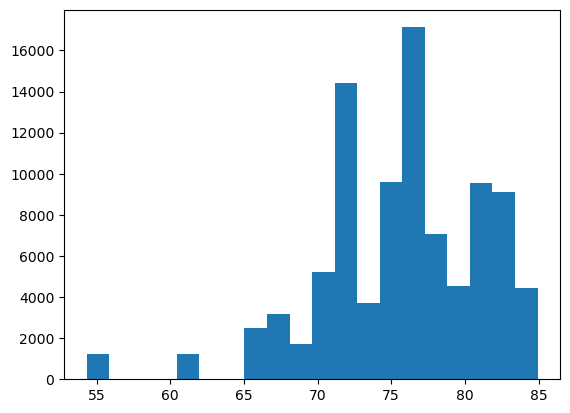

In [50]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import colors
from matplotlib.ticker import PercentFormatter

# Create a random number generator with a fixed seed for reproducibility
n_bins = 20

fig, axs = plt.subplots()

# We can set the number of bins with the *bins* keyword argument.
axs.hist(df['lifeexpect'], bins=n_bins)

plt.show()